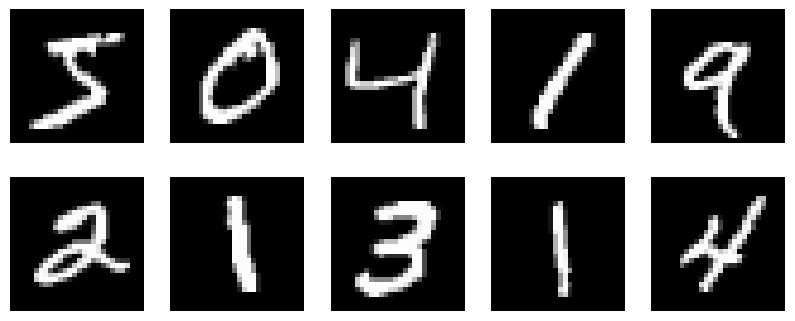

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from src.ppca import ppca_closed_form, mppca, compute_responsibilities, device, compute_probabilities
import torch as th
th.set_grad_enabled(False)
# Load the MNIST dataset
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist['data'], mnist['target']

# Reshape the data for visualization (28x28 images)
X_images = X.values.reshape(-1, 28, 28)

# Display the first 10 images from the dataset
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_images[i], cmap='gray')
    plt.axis('off')
plt.show()
X = th.tensor(X.values)

In [2]:
X = X[:5000].float().to(device)
print(X.shape)

torch.Size([5000, 784])


In [19]:
k = 10
q = 700

W_mppca, mu_mppca, sigma_mppca, pi = mppca(X, q=q, k=k)

sigma_squared: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')


  0%|          | 0/100 [00:00<?, ?it/s]

Finished in 99 iterations with update size 4057.319945240978


In [46]:
from pathlib import Path
import time
dir = Path(f"results/mppca/{str(int(time.time()))}")
dir.mkdir(parents=True, exist_ok=True)
res = [W_mppca, mu_mppca, sigma_mppca, pi]
res_name = ["W", "mu", "sigma", "pi"]
for r, n in zip(res, res_name):
    th.save(r, dir / f"{n}.pt")

In [28]:
from src.ppca import compute_Z, compute_responsibilities
from collections import defaultdict
reconstruction_errors = defaultdict(list)
# Compute the reconstruction of the data :
print(f"MPPCA computed")
d = X.shape[1]
# Start by computing all latent variables: z^m = M^(-1) W^mT (x - mu^m)
Z = compute_Z(W_mppca, X, mu_mppca, sigma_mppca, q, device) # Z is of shape (M, N, q)
# Then reconstruct the data using x_n = Sum_M Rnm(W^m z_n^m + mu^m)
R = compute_responsibilities(X, W_mppca, mu_mppca, sigma_mppca, pi, d, device) # R is of shape (M, N)
X_mppca_reconstructed = (th.einsum("kdq, knq -> knd", W_mppca, Z) + mu_mppca.unsqueeze(1))
X_mppca_reconstructed = R.unsqueeze(-1) * X_mppca_reconstructed
X_mppca_reconstructed = X_mppca_reconstructed.sum(dim=0)
print(f"MPPCA reconstructed")
# mppca_size = k * (N * q + q * d + d + 1)
# mppca_compression_ratio = mppca_size / original_size
mppca_reconstruction_error = th.mean((X - X_mppca_reconstructed) ** 2).item()

# compression_ratios['MPPCA'].append(mppca_compression_ratio)
reconstruction_errors['MPPCA'].append(mppca_reconstruction_error)

MPPCA computed
MPPCA reconstructed


In [29]:
reconstruction_errors

defaultdict(list, {'MPPCA': [3.0790148044821316e-12]})

In [18]:
compute_responsibilities(X, W_mppca, mu_mppca, sigma_mppca, pi, d=X.shape[1], device=device, normalize=False
    ).shape

torch.Size([10, 5000])

In [20]:
from src.ppca import compute_probabilities
probs = compute_probabilities(X, W_mppca, mu_mppca, sigma_mppca, pi, d=X.shape[1], device=device)

In [21]:
probs.max()

tensor(317.9873, device='cuda:0', dtype=torch.float64)

In [23]:
probs = compute_probabilities(
    X, W_mppca, mu_mppca, sigma_mppca, pi, d=X.shape[1], device=device
)
print(probs.shape)
import plotly.express as px

# Create a histogram of the probabilities
fig = px.histogram(
    probs.cpu().numpy(),
    nbins=100,
    title="Histogram of Probabilities",
    labels={"value": "Probability"},
)
fig.update_layout(xaxis_title="Probability", yaxis_title="Count")
fig.show()

[autoreload of src.ppca failed: Traceback (most recent call last):
  File "c:\Users\Travail\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\extensions\autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "c:\Users\Travail\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\extensions\autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "c:\Users\Travail\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\extensions\autoreload.py", line 397, in update_generic
    update(a, b)
  File "c:\Users\Travail\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\extensions\autoreload.py", line 309, in update_function
    setattr(old, name, getattr(new, name))
ValueError: compute_Z() requires a code object with 2 free vars, not 2392296783872
]


torch.Size([5000])


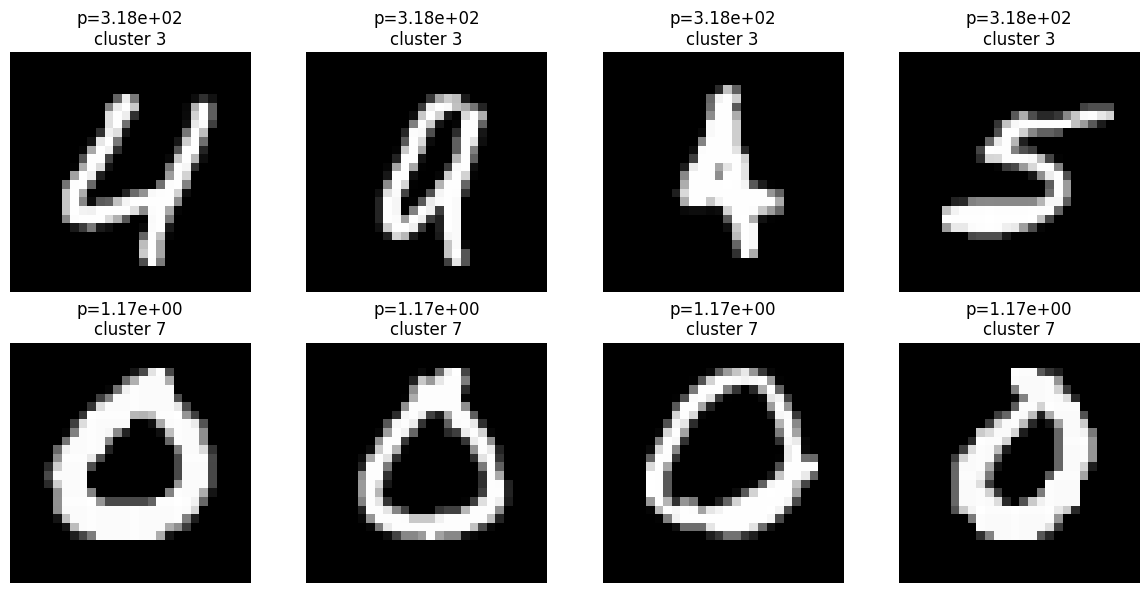

In [26]:
# Get indices of 4 most and least probable digits
most_probable_indices = probs.argsort(descending=True)[:4]
least_probable_indices = probs.argsort(descending=False)[:4]

# Get cluster assignments
responsibilities = compute_responsibilities(X, W_mppca, mu_mppca, sigma_mppca, pi, d=X.shape[1], device=device)
clusters = responsibilities.argmax(dim=0)

# Create figure with 2 rows and 4 columns
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

# Plot 4 most probable digits on first row
for i, idx in enumerate(most_probable_indices):
    axes[0,i].imshow(X_images[idx], cmap='gray')
    axes[0,i].axis('off')
    axes[0,i].set_title(f'p={probs[idx]:.2e}\ncluster {clusters[idx]}')

# Plot 4 least probable digits on second row  
for i, idx in enumerate(least_probable_indices):
    axes[1,i].imshow(X_images[idx], cmap='gray')
    axes[1,i].axis('off')
    axes[1,i].set_title(f'p={probs[idx]:.2e}\ncluster {clusters[idx]}')

plt.tight_layout()
plt.show()

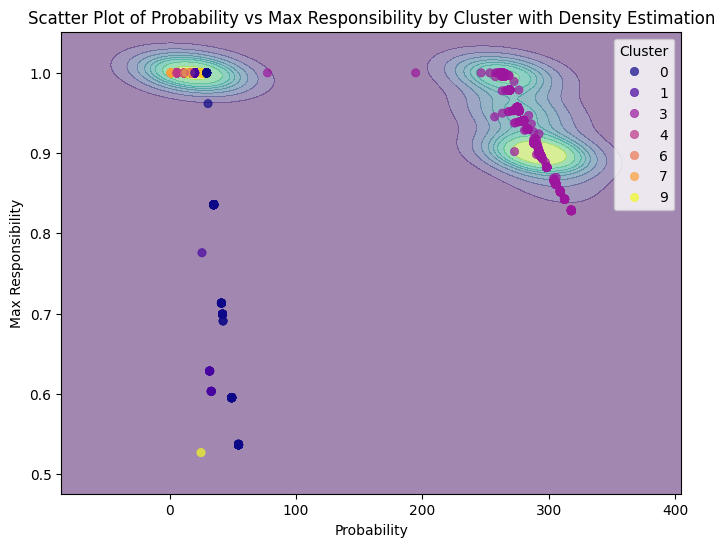

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the maximum responsibility for each point
max_responsibility = responsibilities.max(dim=0).values

# Create a DataFrame for correlation analysis
import pandas as pd

data = pd.DataFrame({
    'Probability': probs.cpu().numpy(),
    'Max Responsibility': max_responsibility.cpu().numpy(),
    'Cluster': responsibilities.argmax(dim=0).cpu().numpy()  # Add cluster information
})

# Plot a scatter plot with color per cluster and add a density estimation
plt.figure(figsize=(8, 6))
sns.kdeplot(data=data, x='Probability', y='Max Responsibility', fill=True, cmap='viridis', alpha=0.5, thresh=0)
sns.scatterplot(x='Probability', y='Max Responsibility', hue='Cluster', data=data, palette='plasma', edgecolor=None, alpha=0.7)
plt.title('Scatter Plot of Probability vs Max Responsibility by Cluster with Density Estimation')
plt.xlabel('Probability')
plt.ylabel('Max Responsibility')
plt.legend(title='Cluster')
plt.show()


In [36]:
# Create a figure with plotly that shows the histogram of probabilities
# with each cluster colored differently
import plotly.graph_objects as go

# Get cluster assignments if not already computed
responsibilities = compute_responsibilities(X, W_mppca, mu_mppca, sigma_mppca, pi, d=X.shape[1], device=device)
clusters = responsibilities.argmax(dim=0)

# Create a separate trace for each cluster
for k in range(len(pi)):
    fig = go.Figure()
    cluster_probs = probs[clusters == k].cpu().numpy()
    fig.add_trace(go.Histogram(
        x=cluster_probs,
        name=f'Cluster {k}',
        # nbinsx=100,
        opacity=0.7,
        # histnorm='probability',
        bingroup=k  # Group bars by cluster to avoid overlap
    ))

    fig.update_layout(
        title=f"Histogram of Probabilities for cluster {k}",
        xaxis_title="Probability",
        yaxis_title="Count",
        barmode='overlay'
    )
    fig.show()
